In [102]:
import json
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import tabulate
import numpy as np
import math

from itertools import cycle, islice


from collect_data import collect_statistics

In [103]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    #'text.usetex': True,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [136]:
def my_3d_plot(x, y, values, plot_name, z_lim=None, save_dir=None):
    y_offset = 5
    
    # prepare data   
    X, Y = np.meshgrid(x, y)
    Z = np.transpose(np.array(values))
    
    
    fig = plt.figure()
    ax = Axes3D(fig)
      
    # plot the data
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # add contour lines for readability
    print(np.min(values[0]))
    min_index = np.argmin(values[0])
    max_index = np.argmax(values[0])
    
    median_index = list(values[0]).index(np.percentile(values[0], 50, interpolation='nearest'))

    print(median_index)
    lvls = [min_index, median_index, max_index]
    colors = ['darkslateblue', 'forestgreen', 'indianred']
    temp = list(zip(lvls, colors))
    temp.sort(key=lambda x: x[0])
    display(temp)
    lvls, colors = zip(*temp)
    display(lvls)
    display(colors)
    
    # TODO: 40 is not displayed properly
    if lvls[2] == 40:
        lvls = list(lvls)
        lvls[2] = 39
    #lvls = [20,30,39]
    cset = ax.contour(X, Y, Z, zdir='y', levels=lvls, offset=-y_offset, colors=colors)

    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(plot_name)
    plt.xticks(x)
    ax.view_init(30, 25)
    
    if z_lim:
        ax.set_zlim([0, z_lim])

    #ax.set_ylim([-y_offset, len(y)+y_offset])
    ax.set_ylim([-y_offset, len(y)+y_offset])
    
    ax.set_xlabel("Available cores", labelpad=10)
    ax.set_ylabel("GDB version", labelpad=10)

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("Duration (minutes)", rotation=90, labelpad=10)
    
    #fig.colorbar.remove()
    
    if save_dir:
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.pdf',  bbox_inches='tight')
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.png',  bbox_inches='tight', dpi=300)
        
    plt.show()


def plot_all(appname, collections, parallizations, performance_frame):
    for collection in collections:
        values_incr = []
        values_batch = []
        for parallelization in parallizations:
            values_incr.append(np.array(performance_frame[collection+'-'+parallelization+'-Inc']))
            values_batch.append(np.array(performance_frame[collection+'-'+parallelization+'-Batch']))


        x = [int(x.replace('parallel_', '')) for x in parallizations]
        y = np.arange(0, len(performance_frame), 1) # 41

        z_lim = performance_frame.max().max()
        z_lim += z_lim/10
        z_lim = 5 * round(z_lim/5)

        #my_3d_plot(x, y, values_incr, '%s %s Incr' % (appname, collection), z_lim=60, save_dir=out_dir)
        my_3d_plot(x, y, values_incr, '%s %s Incr' % (appname, collection), save_dir=out_dir)

        #my_3d_plot(x, y, values_batch, '%s %s Batch' % (appname, collection), z_lim=60, save_dir=out_dir)
        my_3d_plot(x, y, values_batch, '%s %s Batch' % (appname, collection), save_dir=out_dir)


    #     for angle in range(0, 360):
    #         ax.view_init(30, angle)
    #         plt.draw()
    #         plt.pause(.001)


In [112]:
def load_data(app_name, collection, parallelization, suffix, event_dir, memory_dir,
              exp_log_dir=None, performance_frame=pd.DataFrame(), run_details_frame=pd.DataFrame()):
    
    """
    event_dir and memory_dir are global
    performance_frame and run_details_frame are global
    """
    if exp_log_dir:
        app_exp_name = app_name + '-' + collection + '-' + parallelization + suffix
        print('load %s from csv' % app_exp_name)
        
        with open(os.path.join(exp_log_dir, app_exp_name, app_exp_name+'-performance.csv'), 'r') as f:
            df = pd.read_csv(f, sep=',')
#             iterations = max(iterations, len(df['Iteration']))
            df = df.set_index('Iteration')
    else:
        exp_name = app_name + '-' + collection + '-' + parallelization + suffix

        print('collect %s from logs' % exp_name)
        df = collect_statistics(exp_name, event_dir=event_dir, memory_dir=memory_dir) 

    print('Adding %s entries' % len(df))
    performance_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
    performance_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
    
    if not exp_log_dir:
        run_details_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
        run_details_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
        run_details_frame[collection+'-'+parallelization+'-Inc F&M'] = df['Incremental F&M Duration']
        run_details_frame[collection+'-'+parallelization+'-Batch F&M'] = df['Batch F&M Duration']   
    return performance_frame, run_details_frame

In [130]:


def get_dyldo_core():
    performance_frame = pd.DataFrame() 
    run_details_frame = pd.DataFrame()
    
    out_dir = join('..', 'plots', 'parallelization_exp')
    event_dir = join('..', 'data', 'spark_logs-parallelization_exp')
    memory_dir = join(event_dir, 'spark-memory')
    exp_log_dir = join('..', 'data', 'exp_logs-parallelizaton_exp', 'experiments')

    appname = 'DyLDO-core'
    data_size_dir = 'DyLDO-core'   
    collections = ['attribute', 'type']
    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
    suffix = '-test-2'
    
    for collection in collections:
        for parallelization in parallizations:
            performance_frame, run_details_frame = load_data(appname, collection, parallelization, suffix,
                                                             event_dir, memory_dir,
                                                             performance_frame=performance_frame,
                                                             run_details_frame=run_details_frame)
            
    # BSBM-type-parallel_1-test-1
    # 
    
    
    # appname+'-'+collection+'-'+parallelization+suffix
    collections = ['schemex']
    parallizations = ['parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
    suffix = '-test-1' # schemex
    
    for collection in collections:
        for parallelization in parallizations:
            performance_frame, run_details_frame = load_data(appname, collection, parallelization, suffix,
                                                             event_dir, memory_dir,
                                                             performance_frame=performance_frame,
                                                             run_details_frame=run_details_frame)

    if len(performance_frame) > 23:
        performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
        run_details_frame = run_details_frame.drop(run_details_frame.index[[21,22]])

    # ms -> minutes
    convert = lambda x: x / 1000 / 60
    performance_frame = performance_frame.applymap(convert)  
    run_details_frame = run_details_frame.applymap(convert)

#     display(performance_frame.head())
#     display(run_details_frame.head())
    return performance_frame, run_details_frame  

In [131]:
def get_bsbm():
    performance_frame = pd.DataFrame() 
    run_details_frame = pd.DataFrame()
    
    out_dir = join('..', 'plots', 'parallelization_exp')
    event_dir = join('..', 'data', 'spark_logs-parallelization_exp')
    memory_dir = join(event_dir, 'spark-memory')
    exp_log_dir = join('..', 'data', 'exp_logs-parallelizaton_exp', 'experiments')
    
    appname = 'BSBM'
    data_size_dir = 'BSBM'

    event_dir = join('..', 'data', 'first_spark_logs-parallelization_exp') 
    collections = ['attribute', 'schemex', 'type'] #, 
    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
    suffix = '-test-2' # schemex
    
    for collection in collections:
        for parallelization in parallizations:
            performance_frame, run_details_frame = load_data(appname, collection, parallelization, suffix,
                                                             event_dir, memory_dir,
                                                             performance_frame=performance_frame,
                                                             run_details_frame=run_details_frame)

    # ms -> minutes
    convert = lambda x: x / 1000 / 60
    performance_frame = performance_frame.applymap(convert)  
    run_details_frame = run_details_frame.applymap(convert)

#     display(performance_frame.head())
#     display(run_details_frame.head())
    return performance_frame, run_details_frame  

In [137]:
def plot_dyldo(performance_frame):
    appname = 'DyLDO-core'
    data_size_dir = 'DyLDO-core'
    
    collections = ['attribute', 'type']

    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
    
    plot_all(appname, collections, parallizations, performance_frame)
    
    collections = ['schemex']
    parallizations = ['parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']

    plot_all(appname, collections, parallizations, performance_frame)
    
    
def plot_bsbm(performance_frame):
    appname = 'BSBM'
    data_size_dir = 'BSBM'
    collections = ['attribute', 'schemex', 'type']
    parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']

    plot_all(collections, parallizations, performance_frame)
    

collect DyLDO-core-attribute-parallel_1-test-2 from logs
Adding 51 entries
collect DyLDO-core-attribute-parallel_2-test-2 from logs
Adding 51 entries
collect DyLDO-core-attribute-parallel_4-test-2 from logs
Adding 51 entries
collect DyLDO-core-attribute-parallel_8-test-2 from logs
Adding 51 entries
collect DyLDO-core-attribute-parallel_16-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_1-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_2-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_4-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_8-test-2 from logs
Adding 51 entries
collect DyLDO-core-type-parallel_16-test-2 from logs
Adding 51 entries
collect DyLDO-core-schemex-parallel_2-test-1 from logs
Adding 51 entries
collect DyLDO-core-schemex-parallel_4-test-1 from logs
Adding 51 entries
collect DyLDO-core-schemex-parallel_8-test-1 from logs
Adding 51 entries
collect DyLDO-core-schemex-parallel_16-test-1 from log

(49, 28)

18.50746666666667
34


[(0, 'indianred'), (34, 'forestgreen'), (40, 'darkslateblue')]

(0, 34, 40)

('indianred', 'forestgreen', 'darkslateblue')

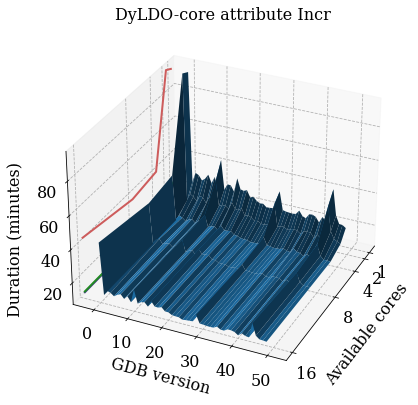

157.42671666666666
41


[(18, 'indianred'), (36, 'darkslateblue'), (41, 'forestgreen')]

(18, 36, 41)

('indianred', 'darkslateblue', 'forestgreen')

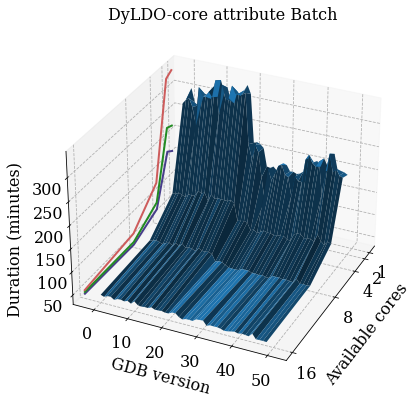

16.8978
22


[(15, 'indianred'), (22, 'forestgreen'), (40, 'darkslateblue')]

(15, 22, 40)

('indianred', 'forestgreen', 'darkslateblue')

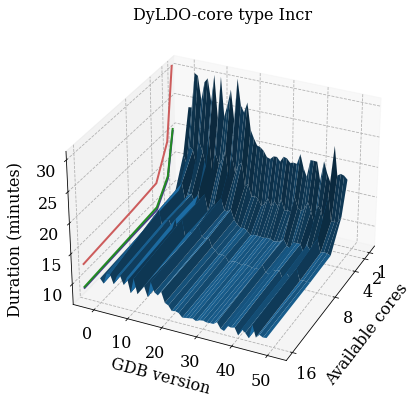

878.9196833333333
21


[(10, 'indianred'), (21, 'forestgreen'), (36, 'darkslateblue')]

(10, 21, 36)

('indianred', 'forestgreen', 'darkslateblue')

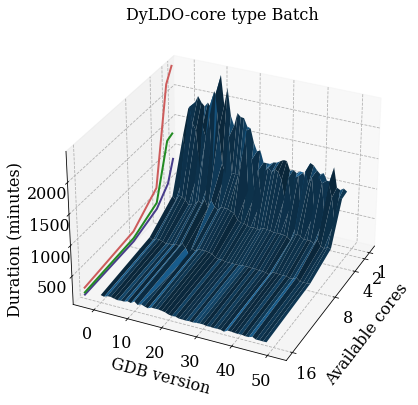

TypeError: plot_all() takes 3 positional arguments but 4 were given

In [133]:
hide_legend = False
performance_frame, run_details_frame = get_dyldo_core()
display(performance_frame.shape)


18.50746666666667
34


[(0, 'indianred'), (34, 'forestgreen'), (40, 'darkslateblue')]

(0, 34, 40)

('indianred', 'forestgreen', 'darkslateblue')

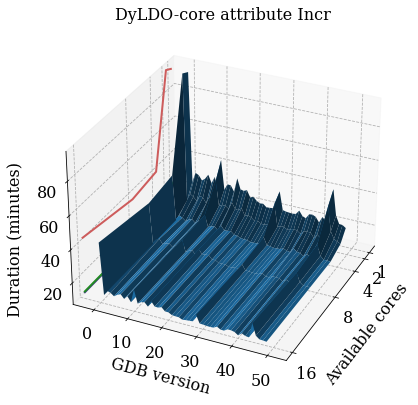

157.42671666666666
41


[(18, 'indianred'), (36, 'darkslateblue'), (41, 'forestgreen')]

(18, 36, 41)

('indianred', 'darkslateblue', 'forestgreen')

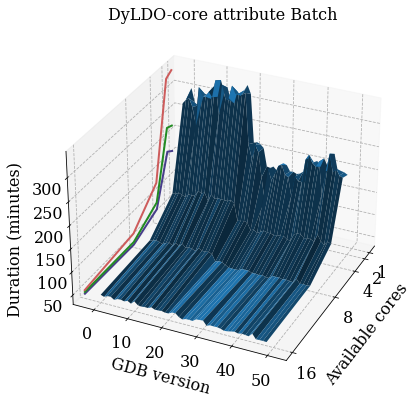

16.8978
22


[(15, 'indianred'), (22, 'forestgreen'), (40, 'darkslateblue')]

(15, 22, 40)

('indianred', 'forestgreen', 'darkslateblue')

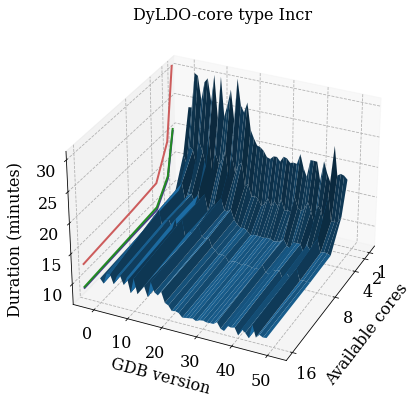

878.9196833333333
21


[(10, 'indianred'), (21, 'forestgreen'), (36, 'darkslateblue')]

(10, 21, 36)

('indianred', 'forestgreen', 'darkslateblue')

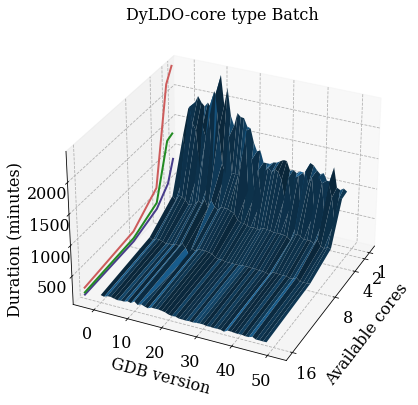

14.150866666666667
1


[(1, 'forestgreen'), (31, 'darkslateblue'), (44, 'indianred')]

(1, 31, 44)

('forestgreen', 'darkslateblue', 'indianred')

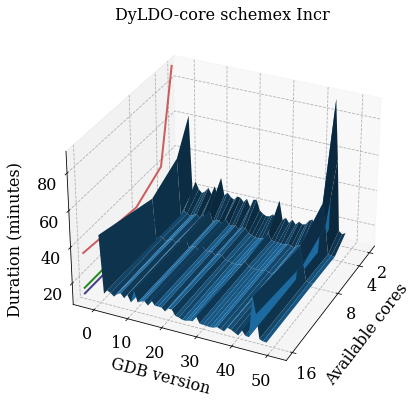

81.78099999999999
38


[(10, 'indianred'), (24, 'darkslateblue'), (38, 'forestgreen')]

(10, 24, 38)

('indianred', 'darkslateblue', 'forestgreen')

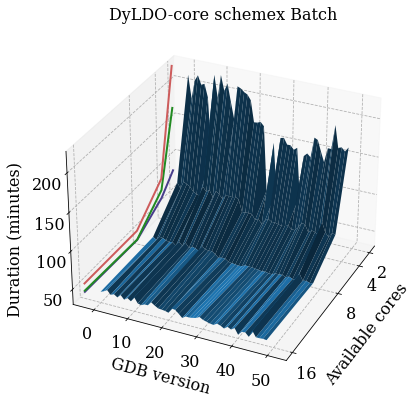

In [138]:
plot_dyldo(performance_frame)

In [118]:
hide_legend = False
performance_frame, run_details_frame = get_bsbm()
display(performance_frame.shape)

collect BSBM-attribute-parallel_1-test-2 from logs
Adding 41 entries
collect BSBM-attribute-parallel_2-test-2 from logs
Adding 41 entries
collect BSBM-attribute-parallel_4-test-2 from logs
Adding 41 entries
collect BSBM-attribute-parallel_8-test-2 from logs
Adding 41 entries
collect BSBM-attribute-parallel_16-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_1-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_2-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_4-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_8-test-2 from logs
Adding 41 entries
collect BSBM-schemex-parallel_16-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_1-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_2-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_4-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_8-test-2 from logs
Adding 41 entries
collect BSBM-type-parallel_16-test-2 from logs
Adding 41 entri

(41, 30)

In [142]:
performance_frame

,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_4-Inc,attribute-parallel_4-Batch,attribute-parallel_8-Inc,attribute-parallel_8-Batch,attribute-parallel_16-Inc,attribute-parallel_16-Batch,...,type-parallel_16-Inc,type-parallel_16-Batch,schemex-parallel_2-Inc,schemex-parallel_2-Batch,schemex-parallel_4-Inc,schemex-parallel_4-Batch,schemex-parallel_8-Inc,schemex-parallel_8-Batch,schemex-parallel_16-Inc,schemex-parallel_16-Batch
Iteration,,,,,,,,,,,,,,,,,,,,,
0,92.857167,283.901700,95.112483,283.088183,39.834633,106.987850,37.096467,54.417700,43.252483,46.691500,...,10.675917,160.313450,63.154017,214.155250,45.355550,85.436567,36.534833,45.070883,45.761983,44.293317
1,25.812483,305.867783,17.379867,292.061767,12.174217,107.851033,12.276383,55.475617,12.194617,43.912917,...,9.950250,146.388517,19.602433,183.656117,12.919417,78.111217,13.269083,42.087783,13.535433,46.122817
2,31.759583,275.939233,22.008100,296.629633,15.491433,112.289467,15.663150,58.446567,15.232383,47.556050,...,11.729667,171.154300,25.807917,208.172267,15.638283,88.576617,16.081567,47.431783,15.827967,48.791250
3,30.771333,271.406067,20.651500,279.241017,14.719383,109.025450,16.397883,55.528250,14.518000,47.938517,...,11.784817,172.928633,21.691667,216.158983,14.616800,86.042883,15.257333,46.838550,14.889667,43.700750
4,27.845867,277.382283,18.527233,239.947183,13.056583,106.222317,13.591733,53.378167,12.988733,43.012300,...,10.292700,159.205850,19.955900,204.648283,13.642883,83.734733,13.608033,44.743133,13.354933,45.593867
5,29.476383,299.970833,22.170250,325.508950,14.488583,113.761633,14.563517,57.456933,14.411433,46.707033,...,11.669267,147.781217,21.328400,206.799567,14.659900,77.652333,15.072950,43.354483,15.205300,42.558633
6,32.439500,298.442533,21.576917,307.210883,15.216233,113.066167,15.048317,60.007667,15.292417,47.288000,...,11.966250,154.428300,23.831533,189.909500,15.759550,75.275067,15.858950,44.555717,16.186583,46.796717
7,27.569767,291.754883,18.407150,308.179867,13.359083,114.828350,13.273800,55.684050,12.965433,45.499667,...,10.582183,152.145033,20.383517,117.367333,13.621783,74.502533,14.434450,40.725817,13.961967,41.806150
8,31.933767,321.128750,23.121133,319.848700,15.291900,126.312883,15.094083,63.069683,15.085733,48.531183,...,11.958117,172.163117,25.714000,221.137917,16.186883,87.688733,16.069983,47.228367,16.264333,45.060933


0.20685
10


[(10, 'forestgreen'), (20, 'indianred'), (40, 'darkslateblue')]

(10, 20, 40)

('forestgreen', 'indianred', 'darkslateblue')

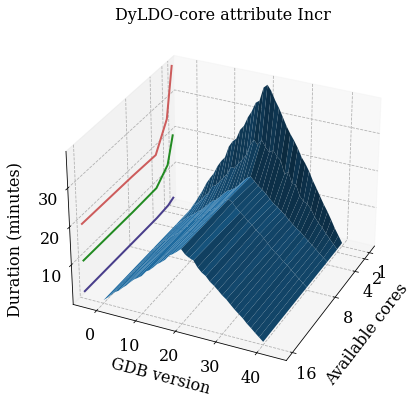

0.21413333333333334
10


[(10, 'forestgreen'), (20, 'indianred'), (40, 'darkslateblue')]

(10, 20, 40)

('forestgreen', 'indianred', 'darkslateblue')

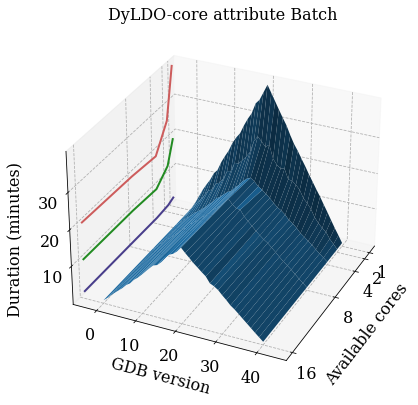

0.31215
10


[(0, 'darkslateblue'), (10, 'forestgreen'), (16, 'indianred')]

(0, 10, 16)

('darkslateblue', 'forestgreen', 'indianred')

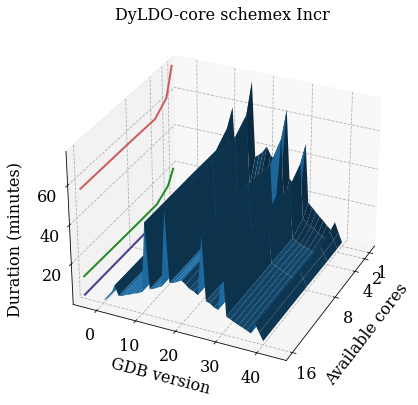

0.26616666666666666
10


[(10, 'forestgreen'), (20, 'indianred'), (40, 'darkslateblue')]

(10, 20, 40)

('forestgreen', 'indianred', 'darkslateblue')

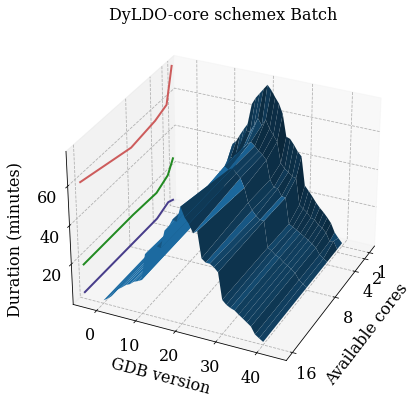

0.19208333333333333
30


[(20, 'indianred'), (30, 'forestgreen'), (40, 'darkslateblue')]

(20, 30, 40)

('indianred', 'forestgreen', 'darkslateblue')

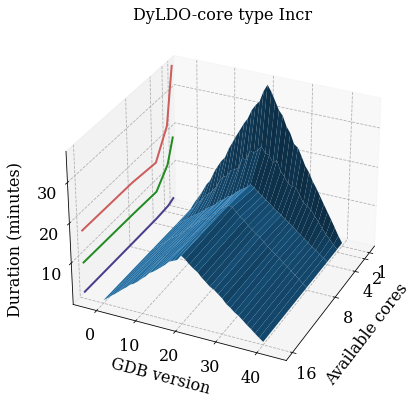

0.2067166666666667
10


[(10, 'forestgreen'), (20, 'indianred'), (40, 'darkslateblue')]

(10, 20, 40)

('forestgreen', 'indianred', 'darkslateblue')

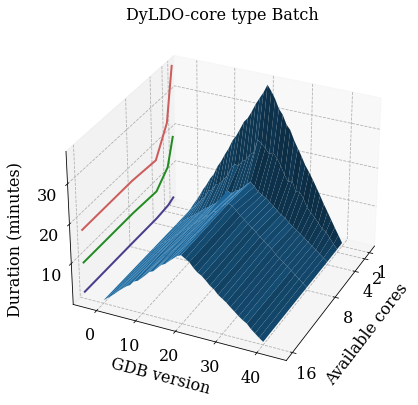

In [120]:
plot_bsbm(performance_frame)

In [121]:
def deduplicate(input_list):
    seen = set()
    new_list = []
    for item in input_list:
        if item not in seen:
            new_list.append(item)
            seen.add(item)
    return new_list


In [123]:
# some speed-up analysis
#display(performance_frame)
speed_up_frame = pd.DataFrame(columns=deduplicate([x.replace('-Inc', '').replace('-Batch', '') for x in performance_frame.columns]))
collections = ['attribute', 'schemex', 'type'] #, 
parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
for collection in collections:
    for parallelization in parallizations:
        speed_up_frame[collection+'-'+parallelization] = performance_frame[collection+'-'+parallelization+'-Batch'] /performance_frame[collection+'-'+parallelization+'-Inc']
        print('batch runs faster than incremental for %s: %s' % (collection+'-'+parallelization, (speed_up_frame[collection+'-'+parallelization] < 1.0).sum()))

display(speed_up_frame.mean())
display(speed_up_frame.std())    
display(speed_up_frame.mean().min())
display(speed_up_frame.mean().max())  

batch runs faster than incremental for attribute-parallel_1: 8
batch runs faster than incremental for attribute-parallel_2: 10
batch runs faster than incremental for attribute-parallel_4: 2
batch runs faster than incremental for attribute-parallel_8: 5
batch runs faster than incremental for attribute-parallel_16: 4
batch runs faster than incremental for schemex-parallel_1: 11
batch runs faster than incremental for schemex-parallel_2: 11
batch runs faster than incremental for schemex-parallel_4: 11
batch runs faster than incremental for schemex-parallel_8: 11
batch runs faster than incremental for schemex-parallel_16: 11
batch runs faster than incremental for type-parallel_1: 4
batch runs faster than incremental for type-parallel_2: 13
batch runs faster than incremental for type-parallel_4: 2
batch runs faster than incremental for type-parallel_8: 2
batch runs faster than incremental for type-parallel_16: 5


attribute-parallel_1     1.018409
attribute-parallel_2     1.043165
attribute-parallel_4     1.033963
attribute-parallel_8     1.028905
attribute-parallel_16    1.040340
schemex-parallel_1       1.375977
schemex-parallel_2       1.573827
schemex-parallel_4       1.864981
schemex-parallel_8       1.822044
schemex-parallel_16      1.846075
type-parallel_1          1.022795
type-parallel_2          1.041140
type-parallel_4          1.038755
type-parallel_8          1.037167
type-parallel_16         1.032067
dtype: float64

attribute-parallel_1     0.026990
attribute-parallel_2     0.074982
attribute-parallel_4     0.027799
attribute-parallel_8     0.034671
attribute-parallel_16    0.047172
schemex-parallel_1       0.472952
schemex-parallel_2       0.618736
schemex-parallel_4       0.860047
schemex-parallel_8       0.835240
schemex-parallel_16      0.851815
type-parallel_1          0.031192
type-parallel_2          0.077044
type-parallel_4          0.038130
type-parallel_8          0.039123
type-parallel_16         0.046413
dtype: float64

1.0184087697173205

1.8649811322821597

In [148]:
parallelization_frame = pd.DataFrame()
for collection in collections:
    for parallization in parallizations:
        try:
            print('[%s] %s Batch Algorithm - mean run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Batch'].mean()))
            print('[%s] %s Batch Algorithm - std run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Batch'].std()))
            print('[%s] %s Batch Algorithm - min run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Batch'].min()))
            print('[%s] %s Batch Algorithm - max run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Batch'].max()))
            
            print('[%s] %s Incremental Algorithm - mean run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Inc'].mean()))
            print('[%s] %s Incremental Algorithm - std run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Inc'].std()))
            print('[%s] %s Incremental Algorithm - min run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Inc'].min()))
            print('[%s] %s Incremental Algorithm - max run time: %.4f' % (collection, parallization, performance_frame[collection+'-'+parallization+'-Inc'].max()))
        except:
            pass

[attribute] parallel_1 Batch Algorithm - mean run time: 237.2615
[attribute] parallel_1 Batch Algorithm - std run time: 60.0730
[attribute] parallel_1 Batch Algorithm - min run time: 157.4267
[attribute] parallel_1 Batch Algorithm - max run time: 337.9403
[attribute] parallel_1 Incremental Algorithm - mean run time: 26.4189
[attribute] parallel_1 Incremental Algorithm - std run time: 11.1627
[attribute] parallel_1 Incremental Algorithm - min run time: 18.5075
[attribute] parallel_1 Incremental Algorithm - max run time: 92.8572
[attribute] parallel_2 Batch Algorithm - mean run time: 239.4884
[attribute] parallel_2 Batch Algorithm - std run time: 66.6135
[attribute] parallel_2 Batch Algorithm - min run time: 108.9263
[attribute] parallel_2 Batch Algorithm - max run time: 347.3882
[attribute] parallel_2 Incremental Algorithm - mean run time: 19.2441
[attribute] parallel_2 Incremental Algorithm - std run time: 12.0466
[attribute] parallel_2 Incremental Algorithm - min run time: 12.5878
[at

batch runs faster than incremental for schemex-parallel_2: 0
batch runs faster than incremental for schemex-parallel_4: 0
batch runs faster than incremental for schemex-parallel_8: 0
batch runs faster than incremental for schemex-parallel_16: 1

schemex-parallel_2     8.431542
schemex-parallel_4     5.491071
schemex-parallel_8     3.074087
schemex-parallel_16    3.262901
dtype: float64

schemex-parallel_2     2.144893
schemex-parallel_4     1.013582
schemex-parallel_8     0.469467
schemex-parallel_16    0.675312
dtype: float64

3.0740870579786934

8.431541932052054


batch runs faster than incremental for type-parallel_1: 0
batch runs faster than incremental for type-parallel_2: 0
batch runs faster than incremental for type-parallel_4: 0
batch runs faster than incremental for type-parallel_8: 0
batch runs faster than incremental for type-parallel_16: 0

type-parallel_1     64.516358
type-parallel_2     77.823218
type-parallel_4     44.076995
type-parallel_8     21.478231
type-parallel_16    14.055382
dtype: float64

type-parallel_1      7.702295
type-parallel_2     20.288294
type-parallel_4      4.452042
type-parallel_8      2.225683
type-parallel_16     1.397660
dtype: float64

14.055382052473432

77.82321756140654



batch runs faster than incremental for attribute-parallel_1: 0
batch runs faster than incremental for attribute-parallel_2: 0
batch runs faster than incremental for attribute-parallel_4: 0
batch runs faster than incremental for attribute-parallel_8: 1
batch runs faster than incremental for attribute-parallel_16: 3

attribute-parallel_1     1.440052
attribute-parallel_2     1.826764
attribute-parallel_4     1.464468
attribute-parallel_8     1.162826
attribute-parallel_16    1.068840
dtype: float64

attribute-parallel_1     0.050394
attribute-parallel_2     0.304808
attribute-parallel_4     0.081707
attribute-parallel_8     0.049375
attribute-parallel_16    0.042953
dtype: float64

1.0688399013235144

1.8267636241144851

In [125]:
t1 = (performance_frame['attribute-parallel_1-Batch'] /performance_frame['attribute-parallel_1-Inc']).mean()
t2 = (performance_frame['attribute-parallel_1-Batch'].sum() /performance_frame['attribute-parallel_1-Inc'].sum())

In [126]:
display(t1)
display(t2)

1.0184087697173205

1.0216032779598676

In [124]:
for collection in collections:
    for parallelization in parallizations:
        macro_avg = (performance_frame['%s-%s-Batch' % (collection, parallelization)] / performance_frame['%s-%s-Inc'  % (collection, parallelization)]).mean()
        macro_std = (performance_frame['%s-%s-Batch' % (collection, parallelization)] / performance_frame['%s-%s-Inc'  % (collection, parallelization)]).std()
        micro_avg = (performance_frame['%s-%s-Batch' % (collection, parallelization)].sum() / performance_frame['%s-%s-Inc'  % (collection, parallelization)].sum())
        print('[%s] %s - Micro Avg: %s' % (collection, parallelization, micro_avg.round(2)))
        print('[%s] %s - Macro Avg: %s' % (collection, parallelization, macro_avg.round(2)))
        print('[%s] %s - Macro std: %s' % (collection, parallelization, macro_std.round(2)))

[attribute] parallel_1 - Micro Avg: 1.02
[attribute] parallel_1 - Macro Avg: 1.02
[attribute] parallel_1 - Macro std: 0.03
[attribute] parallel_2 - Micro Avg: 1.04
[attribute] parallel_2 - Macro Avg: 1.04
[attribute] parallel_2 - Macro std: 0.07
[attribute] parallel_4 - Micro Avg: 1.04
[attribute] parallel_4 - Macro Avg: 1.03
[attribute] parallel_4 - Macro std: 0.03
[attribute] parallel_8 - Micro Avg: 1.03
[attribute] parallel_8 - Macro Avg: 1.03
[attribute] parallel_8 - Macro std: 0.03
[attribute] parallel_16 - Micro Avg: 1.04
[attribute] parallel_16 - Macro Avg: 1.04
[attribute] parallel_16 - Macro std: 0.05
[schemex] parallel_1 - Micro Avg: 1.42
[schemex] parallel_1 - Macro Avg: 1.38
[schemex] parallel_1 - Macro std: 0.47
[schemex] parallel_2 - Micro Avg: 1.57
[schemex] parallel_2 - Macro Avg: 1.57
[schemex] parallel_2 - Macro std: 0.62
[schemex] parallel_4 - Micro Avg: 1.78
[schemex] parallel_4 - Macro Avg: 1.86
[schemex] parallel_4 - Macro std: 0.86
[schemex] parallel_8 - Micro Av

In [28]:
# print((all_frame['batch'] / all_frame['incr']).mean())
# print(all_frame['batch'].sum() / all_frame['incr'].sum())

In [29]:
for col in performance_frame.columns:
    if 'parallel_1-Inc' in col:
        #baseline
        baseline = performance_frame[col]
    elif '-Batch' in col:
        print('%s has faster runs than baseline? %s' % (col, (performance_frame[col] - baseline < 0).sum()))
        

attribute-parallel_1-Batch has faster runs than baseline? 0
attribute-parallel_2-Batch has faster runs than baseline? 0
attribute-parallel_4-Batch has faster runs than baseline? 0
attribute-parallel_8-Batch has faster runs than baseline? 1
attribute-parallel_16-Batch has faster runs than baseline? 1
type-parallel_1-Batch has faster runs than baseline? 0
type-parallel_2-Batch has faster runs than baseline? 0
type-parallel_4-Batch has faster runs than baseline? 0
type-parallel_8-Batch has faster runs than baseline? 0
type-parallel_16-Batch has faster runs than baseline? 0


In [56]:
parallelization_frame = pd.DataFrame()
for collection in collections:
    for i in range(1, len(parallizations)):
        prev = parallizations[i-1]
        current = parallizations[i]
        parallelization_frame[collection+'-'+current+'-Batch'] = performance_frame[collection+'-'+prev+'-Batch'] / performance_frame[collection+'-'+current+'-Batch'] 
        parallelization_frame[collection+'-'+current+'-Inc'] = performance_frame[collection+'-'+prev+'-Inc'] / performance_frame[collection+'-'+current+'-Inc'] 
            
display(parallelization_frame.mean())
display(parallelization_frame.std())

attribute-parallel_2-Batch     1.004828
attribute-parallel_2-Inc       1.421828
attribute-parallel_4-Batch     2.601937
attribute-parallel_4-Inc       1.501395
attribute-parallel_8-Batch     1.903802
attribute-parallel_8-Inc       1.007920
attribute-parallel_16-Batch    1.092540
attribute-parallel_16-Inc      0.990002
type-parallel_2-Batch          1.363527
type-parallel_2-Inc            1.538961
type-parallel_4-Batch          2.553116
type-parallel_4-Inc            1.443578
type-parallel_8-Batch          2.144589
type-parallel_8-Inc            1.034889
type-parallel_16-Batch         1.636900
type-parallel_16-Inc           1.067712
dtype: float64

attribute-parallel_2-Batch     0.115668
attribute-parallel_2-Inc       0.103813
attribute-parallel_4-Batch     0.256525
attribute-parallel_4-Inc       0.172909
attribute-parallel_8-Batch     0.107215
attribute-parallel_8-Inc       0.042330
attribute-parallel_16-Batch    0.170493
attribute-parallel_16-Inc      0.039810
type-parallel_2-Batch          0.396059
type-parallel_2-Inc            0.083247
type-parallel_4-Batch          0.642576
type-parallel_4-Inc            0.086638
type-parallel_8-Batch          0.371587
type-parallel_8-Inc            0.022324
type-parallel_16-Batch         0.133371
type-parallel_16-Inc           0.032182
dtype: float64

In [140]:
# overall gain:
skip_rows = 1
for collection in collections:
    try:
        t_frame = performance_frame[collection+'-parallel_1-Batch'] / performance_frame[collection+'-parallel_16-Batch']
        print('[%s] Speed-up batch 1 to 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (collection, t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))


        t_frame = performance_frame.iloc[skip_rows:][collection+'-parallel_1-Inc'] / performance_frame.iloc[skip_rows:][collection+'-parallel_16-Inc']
        print('[%s] Speed-up incr. 1 to 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (collection, t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))
    except:
        pass

[attribute] Speed-up batch 1 to 16 between 3.7749 and 7.4025 (mean: 5.4239 +- 1.1460)
[attribute] Speed-up incr. 1 to 16 between 2.0087 and 2.2408 (mean: 2.1087 +- 0.0454)
[type] Speed-up batch 1 to 16 between 10.4138 and 12.6591 (mean: 11.2199 +- 0.6263)
[type] Speed-up incr. 1 to 16 between 2.2922 and 2.5809 (mean: 2.4495 +- 0.0619)


In [141]:
# one core incr. vs 16 core batch

for collection in collections:
    try:
        t_frame = performance_frame.iloc[skip_rows:][collection+'-parallel_16-Batch'] / performance_frame.iloc[skip_rows:][collection+'-parallel_1-Inc']
        print('[%s] Speed-up incr. 1 to batch 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (collection, t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))
    except:
        pass


[attribute] Speed-up incr. 1 to batch 16 between 1.1549 and 2.3571 (mean: 1.7871 +- 0.2676)
[type] Speed-up incr. 1 to batch 16 between 4.8942 and 6.9340 (mean: 5.7253 +- 0.5079)


In [149]:
display(performance_frame.iloc[skip_rows:].mean())
display(performance_frame.iloc[skip_rows:].std())
display(performance_frame.iloc[skip_rows:].min())
display(performance_frame.iloc[skip_rows:].max())

attribute-parallel_1-Inc         25.034720
attribute-parallel_1-Batch      236.289836
attribute-parallel_2-Inc         17.663532
attribute-parallel_2-Batch      238.580033
attribute-parallel_4-Inc         11.834798
attribute-parallel_4-Batch       91.185660
attribute-parallel_8-Inc         11.764677
attribute-parallel_8-Batch       47.586828
attribute-parallel_16-Inc        11.856603
attribute-parallel_16-Batch      43.425791
type-parallel_1-Inc              22.384876
type-parallel_1-Batch          1455.942462
type-parallel_2-Inc              14.541830
type-parallel_2-Batch          1130.889084
type-parallel_4-Inc              10.104456
type-parallel_4-Batch           445.720995
type-parallel_8-Inc               9.752447
type-parallel_8-Batch           208.744115
type-parallel_16-Inc              9.108633
type-parallel_16-Batch          128.775465
schemex-parallel_2-Inc           21.470503
schemex-parallel_2-Batch        167.601806
schemex-parallel_4-Inc           13.257578
schemex-par

attribute-parallel_1-Inc         5.602179
attribute-parallel_1-Batch      60.318306
attribute-parallel_2-Inc         4.815577
attribute-parallel_2-Batch      67.011088
attribute-parallel_4-Inc         2.537381
attribute-parallel_4-Batch      22.230847
attribute-parallel_8-Inc         2.492596
attribute-parallel_8-Batch       9.716144
attribute-parallel_16-Inc        2.537572
attribute-parallel_16-Batch      3.626592
type-parallel_1-Inc              4.388741
type-parallel_1-Batch          399.671349
type-parallel_2-Inc              2.841528
type-parallel_2-Batch          379.118212
type-parallel_4-Inc              1.935380
type-parallel_4-Batch          105.724975
type-parallel_8-Inc              1.896315
type-parallel_8-Batch           45.640375
type-parallel_16-Inc             1.591550
type-parallel_16-Batch          30.296860
schemex-parallel_2-Inc          12.075848
schemex-parallel_2-Batch        36.004799
schemex-parallel_4-Inc           4.801305
schemex-parallel_4-Batch        10

attribute-parallel_1-Inc        18.507467
attribute-parallel_1-Batch     157.426717
attribute-parallel_2-Inc        12.587800
attribute-parallel_2-Batch     108.926283
attribute-parallel_4-Inc         8.780233
attribute-parallel_4-Batch      62.706933
attribute-parallel_8-Inc         8.787433
attribute-parallel_8-Batch      35.777183
attribute-parallel_16-Inc        8.809167
attribute-parallel_16-Batch     37.368867
type-parallel_1-Inc             16.897800
type-parallel_1-Batch          878.919683
type-parallel_2-Inc             10.496117
type-parallel_2-Batch          530.778150
type-parallel_4-Inc              7.616833
type-parallel_4-Batch          292.586000
type-parallel_8-Inc              7.496333
type-parallel_8-Batch          141.701367
type-parallel_16-Inc             7.095983
type-parallel_16-Batch          83.623167
schemex-parallel_2-Inc          14.150867
schemex-parallel_2-Batch        81.781000
schemex-parallel_4-Inc           9.630683
schemex-parallel_4-Batch        55

attribute-parallel_1-Inc         43.385167
attribute-parallel_1-Batch      337.940333
attribute-parallel_2-Inc         34.325000
attribute-parallel_2-Batch      347.388217
attribute-parallel_4-Inc         19.916200
attribute-parallel_4-Batch      126.312883
attribute-parallel_8-Inc         19.368483
attribute-parallel_8-Batch       65.100417
attribute-parallel_16-Inc        20.218383
attribute-parallel_16-Batch      51.199283
type-parallel_1-Inc              30.825183
type-parallel_1-Batch          2430.088917
type-parallel_2-Inc              21.111350
type-parallel_2-Batch          2199.764367
type-parallel_4-Inc              14.723467
type-parallel_4-Batch           658.433833
type-parallel_8-Inc              14.168517
type-parallel_8-Batch           310.730350
type-parallel_16-Inc             12.226450
type-parallel_16-Batch          199.199717
schemex-parallel_2-Inc           89.726200
schemex-parallel_2-Batch        222.692567
schemex-parallel_4-Inc           38.616850
schemex-par

In [18]:
mux = pd.MultiIndex.from_product([['1','2','4', '8', '16'], ['incr.','batch']])
df = pd.DataFrame(columns=mux)
df

Empty DataFrame
Columns: [(1, incr.), (1, batch), (2, incr.), (2, batch), (4, incr.), (4, batch), (8, incr.), (8, batch), (16, incr.), (16, batch)]
Index: []

In [19]:
latex_frame = performance_frame.copy()
latex_frame.columns = ['1 core incr.', '1 core batch',
                       '2 core incr.', '2 core batch',
                       '4 core incr.', '4 core batch',
                       '8 core incr.', '8 core batch',
                       '16 core incr.', '16 core batch']
latex_frame.columns = mux
latex_frame.index.rename('GDB Version', True)
latex_frame = latex_frame.round(2)
display(latex_frame.mean())

1   incr.    19.452683
    batch    28.027317
2   incr.    12.502927
    batch    23.224146
4   incr.     8.915366
    batch    13.210000
8   incr.     9.057317
    batch    10.567561
16  incr.    10.046341
    batch    10.737805
dtype: float64

In [20]:
print(latex_frame.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{1} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{4} & \multicolumn{2}{l}{8} & \multicolumn{2}{l}{16} \\
{} &  incr. &  batch &  incr. &  batch &  incr. &  batch &  incr. &  batch &  incr. &  batch \\
GDB Version &        &        &        &        &        &        &        &        &        &        \\
\midrule
0           &   0.30 &   0.42 &   0.22 &   0.24 &   0.15 &   0.16 &   0.16 &   0.14 &   0.18 &   0.16 \\
1           &   2.49 &   3.17 &   1.47 &   2.53 &   0.99 &   1.50 &   0.97 &   1.13 &   1.12 &   1.20 \\
2           &   4.18 &   5.72 &   2.61 &   5.35 &   1.90 &   2.66 &   1.88 &   2.28 &   2.06 &   2.38 \\
3           &   6.35 &   8.50 &   3.91 &   6.19 &   2.73 &   4.32 &   2.90 &   3.40 &   3.21 &   3.38 \\
4           &   8.06 &  11.32 &   4.88 &  12.45 &   3.62 &   5.50 &   3.65 &   4.31 &   4.34 &   4.29 \\
5           &   9.98 &  14.52 &   6.23 &  10.80 &   4.62 &   6.94 &   4.57 &   5.65 &   5.04 &   5.5

# run details


In [57]:
display(run_details_frame.head())

,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_1-Inc F&M,attribute-parallel_1-Batch F&M,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_2-Inc F&M,attribute-parallel_2-Batch F&M,attribute-parallel_4-Inc,attribute-parallel_4-Batch,...,type-parallel_4-Inc F&M,type-parallel_4-Batch F&M,type-parallel_8-Inc,type-parallel_8-Batch,type-parallel_8-Inc F&M,type-parallel_8-Batch F&M,type-parallel_16-Inc,type-parallel_16-Batch,type-parallel_16-Inc F&M,type-parallel_16-Batch F&M
Iteration,,,,,,,,,,,,,,,,,,,,,
0,92.857167,283.901700,69.597667,260.103333,95.112483,283.088183,79.320550,266.743000,39.834633,106.987850,...,2.185100,570.133167,11.355050,277.809350,2.969917,269.031733,10.675917,160.313450,3.057233,152.983833
1,25.812483,305.867783,2.958717,282.671833,17.379867,292.061767,3.319133,277.901133,12.174217,107.851033,...,2.338600,507.697317,10.762417,240.842633,2.344900,232.450850,9.950250,146.388517,2.736283,139.151417
2,31.759583,275.939233,4.654867,248.296017,22.008100,296.629633,5.182967,278.070567,15.491433,112.289467,...,2.813050,601.401667,13.035867,281.897850,3.023433,271.743733,11.729667,171.154300,3.144900,162.449583
3,30.771333,271.406067,3.472917,244.266283,20.651500,279.241017,4.353433,262.364583,14.719383,109.025450,...,2.783733,594.499717,14.168517,275.961233,2.828533,266.004133,11.784817,172.928633,3.221967,164.417917
4,27.845867,277.382283,3.457350,253.676700,18.527233,239.947183,4.116433,225.516167,13.056583,106.222317,...,2.569483,553.930967,11.267050,262.679033,2.559917,253.901550,10.292700,159.205850,2.865150,151.705683


In [58]:
find_and_merge_frame = pd.DataFrame()
for collection in collections:
    for i in range(0, len(parallizations)):
        current = parallizations[i]
        find_and_merge_frame[collection+'-'+current+'-Batch'] = run_details_frame[collection+'-'+current +'-Batch F&M'] / run_details_frame[collection+'-'+current+'-Batch'] 
        find_and_merge_frame[collection+'-'+current+'-Inc'] = run_details_frame[collection+'-'+current+'-Inc F&M'] / run_details_frame[collection+'-'+current+'-Inc'] 
            
display(find_and_merge_frame.mean())
display(find_and_merge_frame.std())

attribute-parallel_1-Batch     0.909583
attribute-parallel_1-Inc       0.167052
attribute-parallel_2-Batch     0.943794
attribute-parallel_2-Inc       0.260654
attribute-parallel_4-Batch     0.910360
attribute-parallel_4-Inc       0.326474
attribute-parallel_8-Batch     0.827826
attribute-parallel_8-Inc       0.314405
attribute-parallel_16-Batch    0.828406
attribute-parallel_16-Inc      0.377422
type-parallel_1-Batch          0.985200
type-parallel_1-Inc            0.064168
type-parallel_2-Batch          0.987828
type-parallel_2-Inc            0.121800
type-parallel_4-Batch          0.981991
type-parallel_4-Inc            0.212975
type-parallel_8-Batch          0.963233
type-parallel_8-Inc            0.226885
type-parallel_16-Batch         0.948438
type-parallel_16-Inc           0.277008
dtype: float64

attribute-parallel_1-Batch     0.011183
attribute-parallel_1-Inc       0.115721
attribute-parallel_2-Batch     0.011034
attribute-parallel_2-Inc       0.128815
attribute-parallel_4-Batch     0.009719
attribute-parallel_4-Inc       0.087064
attribute-parallel_8-Batch     0.013499
attribute-parallel_8-Inc       0.081093
attribute-parallel_16-Batch    0.021914
attribute-parallel_16-Inc      0.082160
type-parallel_1-Batch          0.001766
type-parallel_1-Inc            0.004455
type-parallel_2-Batch          0.003613
type-parallel_2-Inc            0.009264
type-parallel_4-Batch          0.001852
type-parallel_4-Inc            0.008627
type-parallel_8-Batch          0.004714
type-parallel_8-Inc            0.010201
type-parallel_16-Batch         0.004997
type-parallel_16-Inc           0.009782
dtype: float64

# other stuff

In [23]:
import numpy as np
import matplotlib.pyplot as plt




In [24]:
size_frame = pd.DataFrame()
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        if '|V|' not in size_frame:
            size_frame['|V|'] = df['Imprint links']
            
        size_frame[collection+':|V_vs|'] = df['Schema Elements (SE)']
        size_frame[collection+':|E_vs|'] = df['Schema Relations (SR)']


        
size_frame = size_frame.join(edgeframe,how='left')
display(size_frame.head())


NameError: name 'data_dir' is not defined

In [ ]:
display(size_frame['|V|'].min())
display(size_frame['|V|'].max())
display(size_frame['|V|'].mean())
display(size_frame['|V|'].std())

In [ ]:
size_frame.columns = ['|V|', 'SchemEX:|V_vs|','SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|E|']

if appname == 'dyldo_y2019_core':
    if interpolate:
        size_frame = size_frame.drop(size_frame.index[[21,22]])
    else:
        size_frame.loc[21:22,'|V|':'|E|']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
   

if appname == 'dyldo_y2019_full':
    size_frame = size_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
  
display(size_frame)

sorted_frame = size_frame[['SchemEX:|V_vs|', 'SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|V|', '|E|']]

sorted_frame.columns=['SchemEX:$|V_{vs}|$', 'SchemEX:$|E_{vs}|$' 
                    , 'AttrColl:$|V_{vs}|$', 'AttrColl:$|E_{vs}|$'
                    , 'TypeColl:$|V_{vs}|$', 'TypeColl:$|E_{vs}|$', '$|V|$', '$|E|$']

ax = sorted_frame.plot(logy=True, style = ['--','-','--','-','--','-','--','-'], 
                       color=['darkslateblue', 'darkslateblue',
                             'forestgreen','forestgreen',
                             'indianred','indianred', 'dimgray', 'dimgray'])#,yticks=([math.exp(w) for w in np.arange(1, 10, 2)]))
#ax.set_ylim([2500, 80000])color=['dimgray', 'darkslateblue']
#plt.yticks(np.arange(0, iterations, 5.0))
#plt.
plt.xticks(np.arange(0, iterations, ticks))
ax.set_xlabel("GDB version")
ax.set_ylabel("Count")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)
if hide_legend:
    ax.get_legend().remove()
    
plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-sizes.pdf',  bbox_inches = 'tight')

In [ ]:
frames = [None, None, None]
i = 0
iterations = 0
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        #del df['NewlyObservedSchema (SE_new)']
        #del df['DeletedSchemaStructures (SE_del)']

        
        del df['TotalNumberOfNewInstances'] 
        del df['InstanceAddedWithKnownSchema (PE_add)']
        del df['InstancesDeleted (PE_del)']
        del df['ChangedSchemaStructuresBecauseOfNeighbor'] 
        del df['PayloadEntriesAdded'] 
        del df['PayloadEntriesRemoved'] 
        del df['InstanceToSchemaLinksAdded'] 
        del df['InstanceToSchemaLinksRemoved'] 

        del df['TotalNumberOfChangedPayloadElements (real PE_mod)']
        
        del df['TotalNumberOfSchemaElementsWritten']
        del df['TotalNumberOfSchemaElementsDeleted']
        #del df['InstanceNotChanged (PE_mod)']
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')
        print(df.columns)
        df.columns = [collection+'ADD', collection+'DEL', collection+'MOD', collection+'unchanged']    #'Modified pe(v)'
        
        #df.columns = [collection+'MOD-ELEM', collection+'Unchanged v', collection+'ADD-ELEM', collection+'DEL-ELEM']    #'Modified pe(v)'
        #df = df[[collection+'ADD-ELEM', collection+'DEL-ELEM', collection+'MOD-ELEM',collection+'Unchanged v']] #'Modified pe(v)'
        frames[i] = df
        i = i + 1
        
df = pd.concat(frames, sort=False)


df.columns = ['SchemEX:ADD', 'SchemEX:DEL', 'SchemEX:MOD','SchemEX:PAY',
             'AttrColl:ADD', 'AttrColl:DEL', 'AttrColl:MOD','AttrColl:PAY',
             'TypeColl:ADD', 'TypeColl:DEL', 'TypeColl:MOD','TypeColl:PAY']
ax = df.plot(logy=True, style = [':','-','--','-.',':','-','--','-.',':','-','--','-.'], 
             color=['darkslateblue', 'darkslateblue', 'darkslateblue', 'darkslateblue', 
                    'forestgreen', 'forestgreen', 'forestgreen','forestgreen',
                   'indianred', 'indianred', 'indianred','indianred'])
#ax.set_ylabel("Quantity")
#ax.yaxis.set_label_coords(-0.015,1.0)
plt.xticks(np.arange(0, iterations, 5.0))
ax.set_xlabel("GDB version")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)

if hide_legend:
    ax.get_legend().remove()

plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-changes.png', bbox_inches = 'tight')

In [ ]:


    
        
performance_frame = pd.DataFrame() 
run_details_frame = pd.DataFrame()
for collection in collections:
#    new_zero_incr = 0
#    new_zero_batch = 0
    for parallelization in parallizations:
        load_data
#         # collectStatistics(analyze_app, event_dir='/tmp/spark-events', memory_dir='/tmp/spark-memory')   
#         print(appname+'-'+collection+'-'+parallelization+suffix)
#         df = collect_statistics(appname+'-'+collection+'-'+parallelization+suffix, 
#                                event_dir=event_dir, 
#                                memory_dir=memory_dir) 
#         display(df.head())
#         # BSBM-type-parallel_1-test-1
# #         app_exp_name = appname + '-'+collection+'-'+parallelization+suffix
# #         with open(os.path.join(exp_log_dir, app_exp_name, app_exp_name+'-performance.csv'), 'r') as f:
# #             df = pd.read_csv(f, sep=',')
# #             #display(df.head())
# #        iterations = max(iterations, len(df['Iteration']))
# #        df = df.set_index('Iteration')

#         performance_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
#         performance_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']

#         run_details_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
#         run_details_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
#         run_details_frame[collection+'-'+parallelization+'-Inc F&M'] = df['Incremental F&M Duration']
#         run_details_frame[collection+'-'+parallelization+'-Batch F&M'] = df['Batch F&M Duration']        

    

#performance_frame.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
#             'AttrColl:Incr', 'AttrColl:Batch',
#             'TypeColl:Incr', 'TypeColl:Batch']
 
convert = lambda x: x / 1000 / 60
performance_frame = performance_frame.applymap(convert)  
run_details_frame = run_details_frame.applymap(convert)

display(performance_frame.head())
display(run_details_frame.head())

if (appname == 'dyldo_y2019_core' or appname == 'DyLDO-core') and len(performance_frame) > 23:
    performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
    run_details_frame = run_details_frame.drop(run_details_frame.index[[21,22]])
    
if appname == 'dyldo_y2019_full':
    performance_frame = performance_frame.head()
    run_details_frame = run_details_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')